<a href="https://colab.research.google.com/github/sahasubhajit/Speech-Spoofing-/blob/main/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets
!pip install jiwer
!pip install umap-learn
!pip install eer
!pip install speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=81ae8a5424e9d87951f117298e7cb38cc4f9b61398c56edac2c6a19bd4cfd636
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from umap import UMAP
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,  PredefinedSplit
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from eer import eer, eer_tnt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
from speechbrain.utils.metric_stats import EER
import torch
sns.set(style='white', context='poster')

In [ ]:
#!pip freeze > requirements.txt

In [3]:

class MLModel:
    def __init__(self, model_type, use_supervised_umap=False, mapper=False):
        self.model_type = model_type
        self.use_supervised_umap = use_supervised_umap
        self.mapper = mapper

        if self.use_supervised_umap:
            self.umap = UMAP(n_neighbors=20, n_components=2)
            self.scaler = StandardScaler()
        if model_type == 'SVM':
            self.model = SVC(probability=True)
            self.param_grid = {'C': [5, 10], 'kernel': ['linear']}
        elif model_type == 'RandomForest':
            self.model = RandomForestClassifier()
            self.param_grid = {'n_estimators': [50, 75, 100]}
        elif model_type == 'KNN':
            self.model = KNeighborsClassifier()
            self.param_grid = {'n_neighbors': [3, 5, 7]}
        elif model_type == 'LogisticRegression':
            self.model = LogisticRegression()
            self.param_grid = {'C': [0.1, 1, 5]}
        elif model_type == 'NaiveBayes':
            self.model = GaussianNB()
            self.param_grid = {}
        elif model_type == 'XGBoost':
            self.model = xgb.XGBClassifier()
            self.param_grid = {'max_depth': [5, 10, 15], 'learning_rate': [0.1, 0.01]}
        elif model_type == 'DecisionTree':
            self.model = DecisionTreeClassifier()
            self.param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}

        elif model_type == 'MLP':
            self.model = MLPClassifier()
            self.param_grid = {
                'hidden_layer_sizes': [(100,)],
                'activation': ['tanh'],
                'batch_size': [64],
                'learning_rate': ['constant'],
                'alpha': [0.0001]
            }

        else:
            print("Unknown model name!")


    def reduce_dimension(self, X_train, y_train, X_val, y_val, algo_name = 'UMAP', supervised = True):
      if algo_name == 'UMAP':
          umap = UMAP(n_neighbors=10, n_components=2)

          if supervised:
              # Train supervised UMAP on labeled data
              mapper = umap.fit(X_train, y_train)
              embedding = mapper.transform(X_val)
          else:
              # Use unsupervised UMAP on training data
              embedding = umap.fit_transform(X_val)

          # Visualize the projection on the validation data
          fig, ax = plt.subplots(figsize=(14, 10))
          # For simplicity, assuming that y_val has the same number of classes as y_train
          # You may need to adapt this if it's not the case
          classes = [1,0]
          colors = ['red', 'green']  # Adjust colors for more classes

          for i, class_label in enumerate(classes):
              class_indices = np.where(y_val == class_label)
              plt.scatter(embedding[class_indices, 0], embedding[class_indices, 1], s=10, c=colors[i], label=f'Class {class_label}')

          plt.legend()
          plt.title('Dimension reduction via UMAP with Validation Data')
          plt.show()

          return embedding



    def preprocess_input(self, X):
        if self.use_supervised_umap:
            pass
        return X

    def train(self, X_train, y_train, X_val, y_val):
        print("{} is training ...".format(self.model_type))
        # Create the test fold for PredefinedSplit
        train_indices = np.full(len(X_train), -1)  # -1 for training set
        val_indices = np.full(len(X_val), 0)  # 0 for validation set
        test_fold = np.concatenate((train_indices, val_indices))

        # Set up GridSearchCV to find the best number of trees using F1 score
        ps = PredefinedSplit(test_fold=test_fold)
        grid_search = GridSearchCV(self.model, self.param_grid, scoring='f1', cv=ps)
        grid_search.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

        # Get the best model with the optimal number of trees
        best_model = grid_search.best_estimator_

        # Make predictions on the validation set with the best model
        y_pred = best_model.predict(X_val)


        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_val, y_pred)
        precision_val = precision_score(y_val, y_pred)
        recall_val = recall_score(y_val, y_pred)
        f1_val = f1_score(y_val, y_pred)
        print("Validation Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f} (Grid search has made on f1 score only)".format(
            accuracy_val, precision_val, recall_val, f1_val))


        y_pred = best_model.predict(X_train)
        # Calculate accuracy, precision, recall, and F1 score on the validation set
        accuracy_val = accuracy_score(y_train, y_pred)
        precision_val = precision_score(y_train, y_pred)
        recall_val = recall_score(y_train, y_pred)
        f1_val = f1_score(y_train, y_pred)
        print("Training Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_val, precision_val, recall_val, f1_val))


        # Get the best parameters found by grid search
        print("Best parameters:", grid_search.best_params_)
        self.trained_model = best_model









    def compute_eer(self, y_true, y_scores):

        fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

        #compute EER from speechbrain contribution
        print("compute EER from speechbrain contribution")
        y_true = torch.tensor([y_true])
        y_scores = torch.tensor([y_scores])

        positive_scores = y_scores[
            (y_true == 1).nonzero(as_tuple=True)
        ]
        negative_scores = y_scores[
            (y_true != 1).nonzero(as_tuple=True)
        ]

        eer, threshold = EER(positive_scores, negative_scores)



        return eer, eer_threshold, fpr, fnr











    def test(self, X_test, y_test):

        print("Testing {} ...".format(self.model_type))

        if self.trained_model is None:
            print("Fit the model first.")
            return

        # Use the trained model to make predictions on the test set
        y_pred_test = self.trained_model.predict(X_test)

        # Calculate metrics on the test set
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_test = precision_score(y_test, y_pred_test)
        recall_test = recall_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)

        print("Test Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_test, precision_test, recall_test, f1_test))

        # Calculate EER for test set
        y_scores_test = self.trained_model.predict_proba(X_test)[:, 1]
        eer_test, eer_threshold_test, fpr_test, fnr_test = self.compute_eer(y_test, y_scores_test)
        print("eer rate {} and threshold value {}".format(eer_test, eer_threshold_test))




        # Create an interactive ROC-AUC plot with Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=fpr_test, y=1-fnr_test, mode='lines', name='ROC curve'))
        fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, name='Random classifier')

        fig.update_layout(
            title='Receiver Operating Characteristic (ROC) Curve',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
        )

        fig.show()





        return fpr_test, fnr_test, eer_threshold_test




class StackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model_names, meta_model_name = 'NaiveBayes'):
        self.base_models = {}
        self.meta_model = GaussianNB() # Using Naive Bayes as the default meta-classifier
        if meta_model_name == 'DecisionTree':
          self.meta_model = DecisionTreeClassifier()
        else:
          print("Unvalid meta model name given! default meta model has selected")
        self.base_model_names = base_model_names

        # Train base models
        for model_name in self.base_model_names:
            if model_name == 'SVM':
                model = MLModel('SVM')
            elif model_name == 'RandomForest':
                model = MLModel('RandomForest')
            elif model_name == 'KNN':
                model = MLModel('KNN')
            elif model_name == 'LogisticRegression':
                model = MLModel('LogisticRegression')
            elif model_name == 'NaiveBayes':
                model = MLModel('NaiveBayes')
            elif model_name == 'XGBoost':
                model = MLModel('XGBoost')
            elif model_name == 'DecisionTree':
                model = MLModel('DecisionTree')
            else:
                print("Unknown model name!")

            self.base_models[model_name] = model

    def train(self, X_train, y_train, X_val, y_val):
        # Train base models
        for model_name, model in self.base_models.items():
            print("{} is training".format(model_name))
            model.train(X_train, y_train, X_val, y_val)

        # Collect predictions from base models for class 1
        meta_features = []
        for model_name, model in self.base_models.items():
            y_pred_train = model.trained_model.predict_proba(X_train)[:, 1]
            meta_features.append(y_pred_train)

        # Transpose the predictions to have the shape (n_samples, n_models)
        meta_features = np.array(meta_features).T

        # Train the meta-classifier using the meta-features
        self.meta_model.fit(meta_features, y_train)

    def test(self, X_test, y_test):
        # Collect predictions from base models for class 1
        meta_features = []
        for model_name, model in self.base_models.items():
            y_pred_test = model.trained_model.predict_proba(X_test)[:, 1]
            meta_features.append(y_pred_test)

        # Transpose the predictions to have the shape (n_samples, n_models)
        meta_features = np.array(meta_features).T

        # Use the meta-classifier to predict
        y_pred_meta = self.meta_model.predict(meta_features)

        # Calculate metrics on the test set
        accuracy_test = accuracy_score(y_test, y_pred_meta)
        precision_test = precision_score(y_test, y_pred_meta)
        recall_test = recall_score(y_test, y_pred_meta)
        f1_test = f1_score(y_test, y_pred_meta)

        print("Stacking Test Set Metrics - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(
            accuracy_test, precision_test, recall_test, f1_test))


        # Calculate EER for test set
        y_scores_test = self.meta_model.predict_proba(meta_features)[:, 1]



        # Get the MLModel instance for reference
        ml_model_instance = list(self.base_models.values())[0]  # Pick any model instance (assuming they share the same compute_eer method)

        # Access compute_eer from MLModel class instance
        eer_test, eer_threshold_test, fpr_test, fnr_test = ml_model_instance.compute_eer(y_test, y_scores_test)
        print("eer rate {} and threshold value {}".format(eer_test, eer_threshold_test))

        # Create an interactive ROC-AUC plot with Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=fpr_test, y=1-fnr_test, mode='lines', name='ROC curve'))
        fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, name='Random classifier')

        fig.update_layout(
            title='Receiver Operating Characteristic (ROC) Curve',
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
        )

        fig.show()

        return fpr_test, fnr_test, eer_threshold_test



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/LA

/content/drive/MyDrive/LA


In [6]:

df = pd.read_csv("/content/drive/MyDrive/LA/train_embeddings/train_intermediate_embedding_layer_True_layer_index8.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
print(df.shape)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]



df = pd.read_csv("/content/drive/MyDrive/LA/dev_embeddings/dev_intermediate_embedding_layer_True_layer_index8.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
X_val = df.iloc[:, :-1]
y_val = df.iloc[:, -1]




df = pd.read_csv("/content/drive/MyDrive/LA/eval_embeddings/eval_intermediate_embedding_layer_True_layer_index8.csv")
df = df.drop('file_name', axis=1)
df['label'] = df['label'].map({'spoof': 0, 'bonafide': 1})
X_test = df.iloc[:, :-1]
y_test = df.iloc[:, -1]
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(25380, 769)
(25380, 768) (24844, 768) (71237, 768) (25380,) (24844,) (71237,)


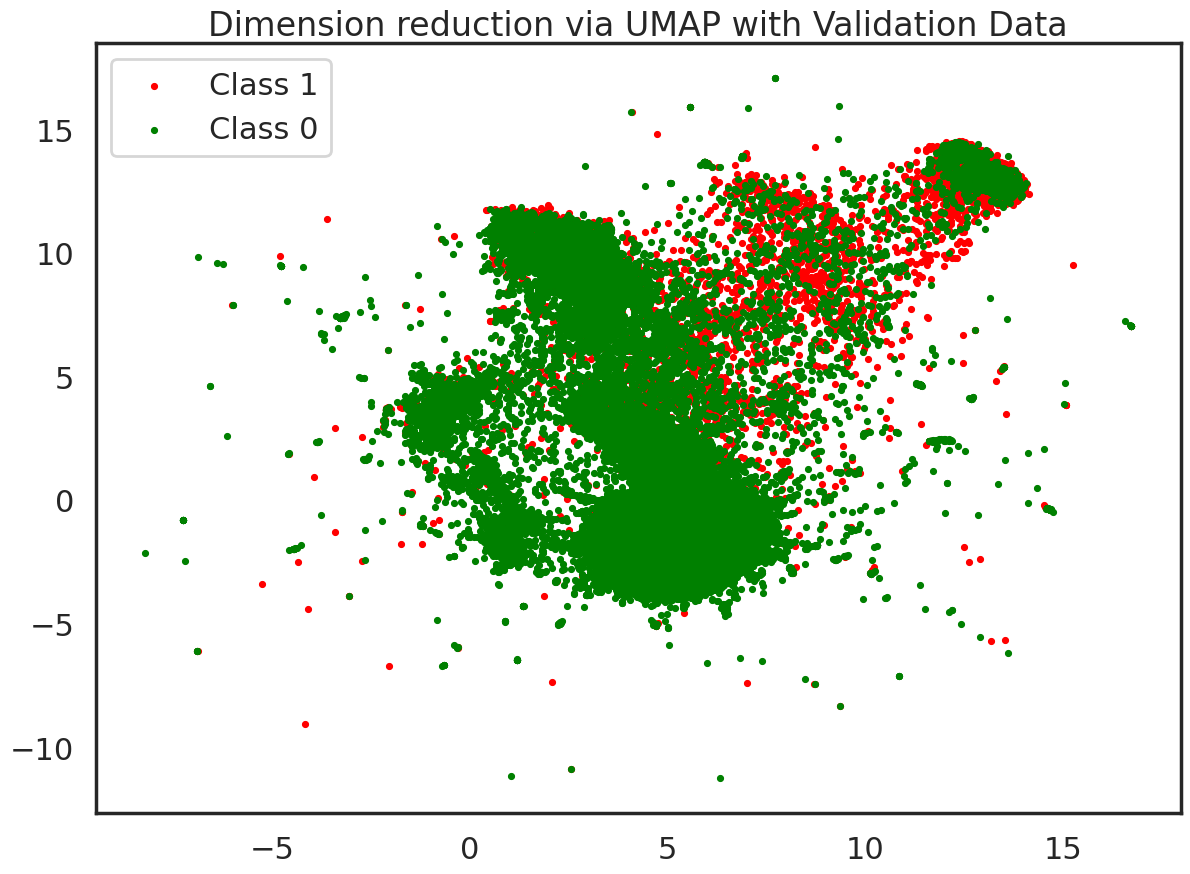

In [8]:
ml_agent = MLModel('KNN')
#ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
#ml_agent.test(X_test, y_test)
X_projection = ml_agent.reduce_dimension(X_train, y_train, X_test, y_test)

In [9]:
ml_agent = MLModel('KNN')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9413, Precision: 0.9764, Recall: 0.4384, F1: 0.6051 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9740, Precision: 0.9913, Recall: 0.7504, F1: 0.8542
Best parameters: {'n_neighbors': 3}
Testing KNN ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Test Set Metrics - Accuracy: 0.9177, Precision: 0.6120, Recall: 0.5547, F1: 0.5819


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



compute EER from speechbrain contribution
eer rate 0.14212831482291222 and threshold value 0.3333333333333333


(array([0.        , 0.01195955, 0.04049654, 0.12164616, 1.        ]),
 array([1.        , 0.73487424, 0.44527532, 0.16261047, 0.        ]),
 0.3333333333333333)

In [10]:
ml_agent = MLModel('RandomForest')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

RandomForest is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Training Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Best parameters: {'n_estimators': 75}
Testing RandomForest ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Test Set Metrics - Accuracy: 0.9408, Precision: 0.8503, Recall: 0.5183, F1: 0.6440


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



compute EER from speechbrain contribution
eer rate 0.0877702459692955 and threshold value 0.26666666666666666


(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.56538618e-05, 1.56538618e-05,
        1.56538618e-05, 3.13077236e-05, 6.26154472e-05, 7.82693090e-05,
        7.82693090e-05, 9.39231708e-05, 1.40884756e-04, 1.87846342e-04,
        2.50461789e-04, 2.97423374e-04, 3.91346545e-04, 5.47885163e-04,
        8.29654676e-04, 1.23665508e-03, 1.58104004e-03, 1.94107886e-03,
        2.41069472e-03, 2.97423374e-03, 3.70996525e-03, 4.53961992e-03,
        5.44754391e-03, 6.21458314e-03, 7.45123822e-03, 8.79747034e-03,
        1.05037413e-02, 1.24135124e-02, 1.42763220e-02, 1.64991703e-02,
        1.87689803e-02, 2.11953289e-02, 2.38877931e-02, 2.72064118e-02,
        3.02745687e-02, 3.39375724e-02, 3.82893460e-02, 4.26411196e-02,
        4.74312013e-02, 5.30509377e-02, 5.91246360e-02, 6.52922576e-02,
        7.26339188e-02, 8.09461194e-02, 8.98844745e-02, 9.97933690e-02,
        1.10860649e-01, 1.23508970e-01, 1.38474062e-01, 1.561942

In [11]:
ml_agent = MLModel('XGBoost')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

XGBoost is training ...
Validation Set Metrics - Accuracy: 0.9920, Precision: 0.9983, Recall: 0.9239, F1: 0.9596 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9948, Precision: 0.9976, Recall: 0.9512, F1: 0.9738
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
Testing XGBoost ...
Test Set Metrics - Accuracy: 0.9571, Precision: 0.7816, Recall: 0.8116, F1: 0.7963
compute EER from speechbrain contribution
eer rate 0.06634524464607239 and threshold value 0.1954641044139862


(array([0.        , 0.        , 0.        , ..., 0.98326602, 0.98329733,
        1.        ]),
 array([1.        , 0.99986404, 0.97675051, ..., 0.        , 0.        ,
        0.        ]),
 0.1954641)

In [12]:
ml_agent = MLModel('NaiveBayes')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
fpr, fnr, eer_threshold_test = ml_agent.test(X_test, y_test)

NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.7398, Precision: 0.2640, Recall: 0.8595, F1: 0.4039 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.7342, Precision: 0.2487, Recall: 0.7992, F1: 0.3794
Best parameters: {}
Testing NaiveBayes ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Test Set Metrics - Accuracy: 0.8585, Precision: 0.4122, Recall: 0.8706, F1: 0.5595


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



compute EER from speechbrain contribution
eer rate 0.13908680528402328 and threshold value 0.9336259753363549


In [13]:
ml_agent = MLModel('DecisionTree')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9987, Precision: 0.9984, Recall: 0.9890, F1: 0.9937 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9993, Precision: 0.9996, Recall: 0.9938, F1: 0.9967
Best parameters: {'criterion': 'entropy', 'max_depth': 15}
Testing DecisionTree ...
Test Set Metrics - Accuracy: 0.9010, Precision: 0.5164, Recall: 0.6476, F1: 0.5746
compute EER from speechbrain contribution


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



eer rate 0.20762551203370094 and threshold value 0.017857142857142856


(array([0.        , 0.06928399, 0.06939357, 0.06953445, 0.06983188,
        0.06997276, 0.07037976, 0.07117811, 0.07130334, 0.07352619,
        0.07371404, 0.07426192, 0.07892677, 0.0806487 , 1.        ]),
 array([1.        , 0.35622026, 0.35567641, 0.35418083, 0.35241332,
        0.35200544, 0.34969409, 0.34915024, 0.34915024, 0.34575119,
        0.34493542, 0.34466349, 0.34153637, 0.33460231, 0.        ]),
 0.017857142857142856)

In [14]:
ml_agent = MLModel('LogisticRegression')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

LogisticRegression is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Validation Set Metrics - Accuracy: 0.9907, Precision: 0.9809, Recall: 0.9274, F1: 0.9534 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9931, Precision: 0.9751, Recall: 0.9570, F1: 0.9660
Best parameters: {'C': 5}
Testing LogisticRegression ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Test Set Metrics - Accuracy: 0.9614, Precision: 0.7575, Recall: 0.9213, F1: 0.8314
compute EER from speechbrain contribution


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



eer rate 0.05043930932879448 and threshold value 0.3213876692924204


(array([0.        , 0.        , 0.        , ..., 0.69974328, 0.69974328,
        1.        ]),
 array([1.00000000e+00, 9.99864038e-01, 9.72671652e-01, ...,
        1.35961931e-04, 0.00000000e+00, 0.00000000e+00]),
 0.3213876692924204)

In [15]:
ml_agent = MLModel('SVM')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

SVM is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Validation Set Metrics - Accuracy: 0.9938, Precision: 0.9862, Recall: 0.9525, F1: 0.9691 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Training Set Metrics - Accuracy: 0.9948, Precision: 0.9819, Recall: 0.9671, F1: 0.9744
Best parameters: {'C': 10, 'kernel': 'linear'}
Testing SVM ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



Test Set Metrics - Accuracy: 0.9502, Precision: 0.6940, Recall: 0.9263, F1: 0.7935


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SVC was fitted without feature names



compute EER from speechbrain contribution
eer rate 0.058326978236436844 and threshold value 0.3558637583937892


(array([0.        , 0.        , 0.        , ..., 0.53429761, 0.7953101 ,
        1.        ]),
 array([1.        , 0.98871516, 0.98436438, ..., 0.        , 0.        ,
        0.        ]),
 0.3558637583937892)

In [ ]:
"""
Make grid search later with the hyperparameters; to evaluate the performance quickly the model is set on the best hyperparameter obtained in the last hidden layer case
            self.param_grid = {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh'],
                'batch_size': [32, 64],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'alpha': [0.0001, 0.001, 0.01]
            }
"""

In [7]:
ml_agent = MLModel('MLP')
ml_agent.train(X_train, y_train, X_val, y_val)  # Set use_supervised_umap to True to use supervised UMAP
ml_agent.test(X_test, y_test)

MLP is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Validation Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Training Set Metrics - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 64, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Testing MLP ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Test Set Metrics - Accuracy: 0.9474, Precision: 0.6717, Recall: 0.9587, F1: 0.7899


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


compute EER from speechbrain contribution


<ipython-input-3-031939653627>:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  y_scores = torch.tensor([y_scores])


eer rate 0.0484020933508873 and threshold value 0.6572656257530417


(array([0.        , 0.        , 0.        , ..., 0.49740146, 0.49740146,
        1.        ]),
 array([1.00000000e+00, 9.93881713e-01, 9.91026513e-01, ...,
        1.35961931e-04, 0.00000000e+00, 0.00000000e+00]),
 0.6572656257530417)

In [17]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9339, Precision: 0.9390, Recall: 0.3807, F1: 0.5417 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9617, Precision: 0.9669, Recall: 0.6450, F1: 0.7738
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.6961, Precision: 0.2323, Recall: 0.8520, F1: 0.3651 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.6900, Precision: 0.2177, Recall: 0.7903, F1: 0.3414
Best parameters: {}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Stacking Test Set Metrics - Accuracy: 0.9085, Precision: 0.5450, Recall: 0.6884, F1: 0.6084
compute EER from speechbrain contribution
eer rate 0.17454678192734718 and threshold value 0.3333333333333333


(array([0.        , 0.00715381, 0.02374691, 0.02723772, 0.06616887,
        0.06621584, 0.08609624, 0.0861432 , 1.        ]),
 array([1.        , 0.84541128, 0.60829368, 0.5846363 , 0.31162475,
        0.31080897, 0.26308634, 0.26295037, 0.        ]),
 0.3333333333333333)

In [18]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes', 'DecisionTree']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9339, Precision: 0.9390, Recall: 0.3807, F1: 0.5417 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9617, Precision: 0.9669, Recall: 0.6450, F1: 0.7738
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.6961, Precision: 0.2323, Recall: 0.8520, F1: 0.3651 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.6900, Precision: 0.2177, Recall: 0.7903, F1: 0.3414
Best parameters: {}
DecisionTree is training
DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9511, Precision: 0.8193, Recall: 0.6707, F1: 0.7376 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9576, Precision: 0.8290, Recall: 0.7345, F1: 0.7789
Best parameters: {'criterion': 'entropy', 'max_depth': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Stacking Test Set Metrics - Accuracy: 0.9196, Precision: 0.6151, Recall: 0.5914, F1: 0.6030
compute EER from speechbrain contribution
eer rate 0.20667079836130142 and threshold value 0.07692307692307693


(array([0.        , 0.0269403 , 0.02733164, 0.02772299, 0.02787953,
        0.02803607, 0.02863091, 0.02881876, 0.03014934, 0.03096334,
        0.03126076, 0.03348361, 0.03378103, 0.03396888, 0.03473592,
        0.0348455 , 0.035049  , 0.03634827, 0.0372875 , 0.03794496,
        0.04038696, 0.040747  , 0.04131054, 0.04199931, 0.04243762,
        0.04260981, 0.04536489, 0.0462102 , 0.04628847, 0.04664851,
        0.04688332, 0.0490592 , 0.04949751, 0.04979493, 0.05029586,
        0.05098463, 0.05247174, 0.05373971, 0.05381798, 0.05402148,
        0.05453805, 1.        ]),
 array([1.        , 0.55268525, 0.54479946, 0.53704963, 0.53351462,
        0.53283481, 0.51828688, 0.51611149, 0.50482665, 0.50020394,
        0.4900068 , 0.48660775, 0.48497621, 0.48076139, 0.47804215,
        0.47777022, 0.47138001, 0.46063902, 0.4575119 , 0.45384092,
        0.42950374, 0.425017  , 0.4199864 , 0.41196465, 0.4114208 ,
        0.4085656 , 0.39211421, 0.38925901, 0.38898708, 0.38803535,
        0.3870

In [19]:
# List of base model names excluding "SVM"
base_model_names = ['KNN', 'NaiveBayes', 'XGBoost', 'DecisionTree']

# Initialize the StackingClassifier with the base models
stacking_classifier = StackingClassifier(base_model_names, 'DecisionTree')

# Assuming you have your train, validation, and test data (X_train, y_train, X_val, y_val, X_test, y_test)

# Train the StackingClassifier
stacking_classifier.train(X_train, y_train, X_val, y_val)

# Test the StackingClassifier on the test data
stacking_classifier.test(X_test, y_test)

KNN is training
KNN is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9339, Precision: 0.9390, Recall: 0.3807, F1: 0.5417 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Training Set Metrics - Accuracy: 0.9617, Precision: 0.9669, Recall: 0.6450, F1: 0.7738
Best parameters: {'n_neighbors': 3}
NaiveBayes is training
NaiveBayes is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Validation Set Metrics - Accuracy: 0.6961, Precision: 0.2323, Recall: 0.8520, F1: 0.3651 (Grid search has made on f1 score only)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names



Training Set Metrics - Accuracy: 0.6900, Precision: 0.2177, Recall: 0.7903, F1: 0.3414
Best parameters: {}
XGBoost is training
XGBoost is training ...
Validation Set Metrics - Accuracy: 0.9803, Precision: 0.9891, Recall: 0.8167, F1: 0.8947 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9861, Precision: 0.9920, Recall: 0.8705, F1: 0.9273
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
DecisionTree is training
DecisionTree is training ...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



Validation Set Metrics - Accuracy: 0.9510, Precision: 0.8174, Recall: 0.6727, F1: 0.7380 (Grid search has made on f1 score only)
Training Set Metrics - Accuracy: 0.9577, Precision: 0.8292, Recall: 0.7357, F1: 0.7796
Best parameters: {'criterion': 'entropy', 'max_depth': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Stacking Test Set Metrics - Accuracy: 0.9260, Precision: 0.6446, Recall: 0.6315, F1: 0.6380
compute EER from speechbrain contribution
eer rate 0.20427319034934044 and threshold value 1.0


(array([0.        , 0.04008954, 1.        ]),
 array([1.        , 0.36845683, 0.        ]),
 1.0)

In [ ]:
"""
import torch
from speechbrain.utils.metric_stats import EER

positive_scores = torch.tensor([0.6, 0.7, 0.8, 0.5])
negative_scores = torch.tensor([0.4, 0.3, 0.2, 0.1])
val_eer, threshold = EER(positive_scores, negative_scores)
val_eer
"""

In [ ]:
y_scores = torch.tensor([0.9,0.1,0.5])
y_true = torch.tensor([1,0,0])
positive_scores = y_scores[
            (y_true == 1).nonzero(as_tuple=True)
        ]

In [ ]:
positive_scores